# Network Exploration and Baseline Analysis

This notebook performs exploratory data analysis (EDA) on the citation network and establishes baseline metrics for our TransE model. We'll examine:

- Network structure and basic statistics
- Node degrees, clustering, and centrality metrics
- Visualization of the current citation network
- Baseline analysis around the seed paper

In [7]:
import sys
print(sys.executable)
!{sys.executable} -m pip install torch networkx pandas matplotlib seaborn neo4j scikit-learn jupyter

/Users/bhs/PROJECTS/citation-map-dashboard/.venv/bin/python
  Using cached torch-2.8.0-cp312-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_learn-1.7.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached scipy-1.16.1-cp312-cp312-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached notebook-7.4.5-py3-none-any.whl.metadata (10 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached ipywidgets-8.1.7-py3-

In [8]:
# Import required libraries
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from dotenv import load_dotenv

# Import our modules
from src.db import Neo4jConnection
from src.data_extraction import load_citation_graph
from src.visualization import (
    plot_network_overview, 
    plot_network_statistics,
    set_portfolio_style
)

# Set up plotting style
set_portfolio_style()
load_dotenv()

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Connect to Neo4j Database

In [10]:
import os 
NEO4J_URI = os.environ.get('NEO4J_URI')
NEO4J_USER = os.environ.get('NEO4J_USER')
NEO4J_PWD = os.environ.get('NEO4J_PWD')


In [11]:
# Connect to Neo4j database
try:
    db = Neo4jConnection()
    if db.test_connection():
        print("✅ Successfully connected to Neo4j database")
    else:
        print("❌ Failed to connect to Neo4j database")
        raise ConnectionError("Database connection failed")
except Exception as e:
    print(f"❌ Database connection error: {e}")
    print("\nPlease check your .env file contains:")
    print(f"NEO4J_URI={NEO4J_URI}")
    print(f"NEO4J_USER={NEO4J_USER}")
    print(f"NEO4J_PWD={NEO4J_PWD}")
    raise

✅ Successfully connected to Neo4j database


## 2. Extract Citation Network Data

In [12]:
# Load citation graph data
print("Extracting citation network from Neo4j...")
extractor = load_citation_graph(db)

print(f"\nDataset Overview:")
print(f"• Papers: {extractor.num_entities:,}")
print(f"• Citations: {len(extractor.citation_edges):,}")
print(f"• Entity mapping size: {len(extractor.paper_to_id):,}")

Extracting citation network from Neo4j...
Extracting citation edges...
Extracting paper metadata...
Extracted 18912 citation edges between 12553 papers

Dataset Overview:
• Papers: 12,553
• Citations: 18,912
• Entity mapping size: 12,553


## 3. Build NetworkX Graph for Analysis

In [13]:
# Build NetworkX graph
print("Building NetworkX graph for analysis...")
G = extractor.build_networkx_graph()

print(f"\nGraph Properties:")
print(f"• Nodes: {G.number_of_nodes():,}")
print(f"• Edges: {G.number_of_edges():,}")
print(f"• Is directed: {G.is_directed()}")
print(f"• Density: {nx.density(G):.6f}")

Building NetworkX graph for analysis...

Graph Properties:
• Nodes: 12,553
• Edges: 18,912
• Is directed: True
• Density: 0.000120


## 4. Comprehensive Network Statistics

In [14]:
# Get comprehensive dataset statistics
print("Computing comprehensive network statistics...")
stats = extractor.get_dataset_stats()

print("\n📊 Network Statistics:")
print("=" * 40)
for key, value in stats.items():
    if isinstance(value, float):
        print(f"{key:<25}: {value:.4f}")
    else:
        print(f"{key:<25}: {value}")

# Store stats for visualization
network_stats = stats

Computing comprehensive network statistics...

📊 Network Statistics:
num_papers               : 12553
num_citations            : 18912
density                  : 0.0001
avg_degree               : 3.0131
is_connected             : False
num_components           : 2


## 5. Node Degree Analysis

In [15]:
# Analyze degree distribution
degrees = dict(G.degree())
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

degree_df = pd.DataFrame({
    'node_id': list(degrees.keys()),
    'total_degree': list(degrees.values()),
    'in_degree': list(in_degrees.values()),
    'out_degree': list(out_degrees.values())
})

print("\n📈 Degree Statistics:")
print(degree_df[['total_degree', 'in_degree', 'out_degree']].describe())


📈 Degree Statistics:
       total_degree     in_degree    out_degree
count  12553.000000  12553.000000  12553.000000
mean       3.013144      1.506572      1.506572
std       31.098623     30.960768      1.315862
min        1.000000      0.000000      0.000000
25%        1.000000      0.000000      1.000000
50%        1.000000      0.000000      1.000000
75%        2.000000      0.000000      1.000000
max     2097.000000   2096.000000     51.000000


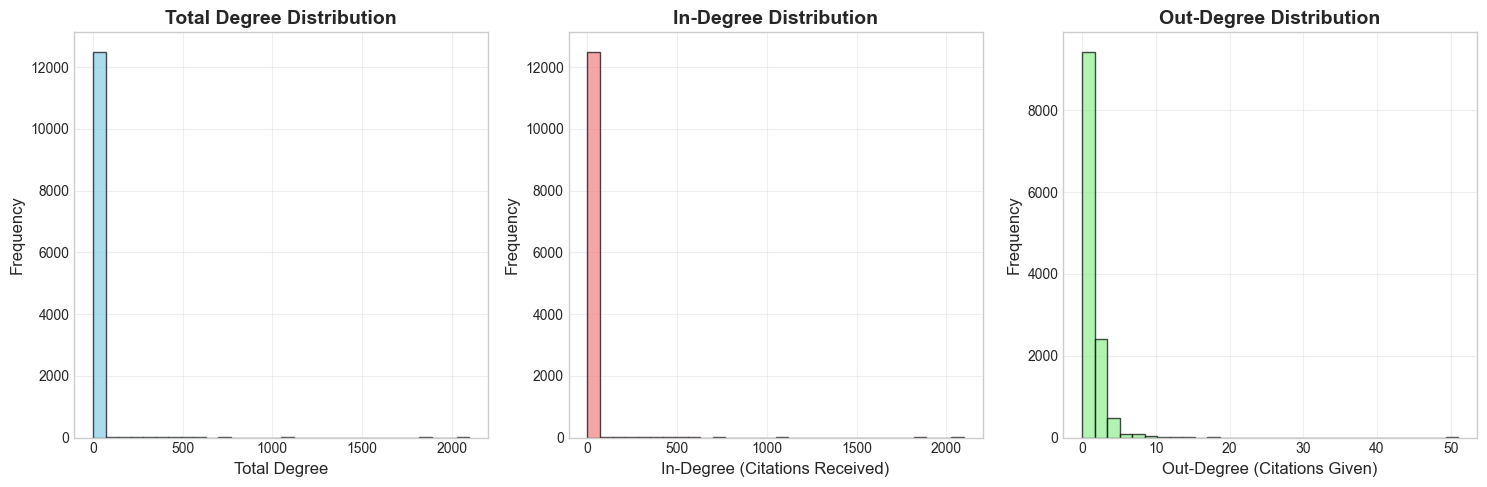

In [16]:
# Plot degree distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Total degree distribution
axes[0].hist(degree_df['total_degree'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Total Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Total Degree Distribution', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# In-degree distribution (citations received)
axes[1].hist(degree_df['in_degree'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('In-Degree (Citations Received)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('In-Degree Distribution', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Out-degree distribution (citations given)
axes[2].hist(degree_df['out_degree'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[2].set_xlabel('Out-Degree (Citations Given)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Out-Degree Distribution', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/degree_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Identify High-Impact Papers

In [17]:
# Find most highly cited papers (high in-degree)
top_cited = degree_df.nlargest(10, 'in_degree')

print("\n🏆 Top 10 Most Cited Papers (by in-degree):")
print("=" * 50)
for idx, row in top_cited.iterrows():
    node_id = row['node_id']
    paper_id = extractor.id_to_paper.get(node_id, 'Unknown')
    title = G.nodes[node_id].get('title', 'No title')[:80]
    citations = row['in_degree']
    print(f"{citations:2d} citations: {title}...")

print("\n🔗 Top 10 Papers by Citations Given (out-degree):")
print("=" * 50)
top_citing = degree_df.nlargest(10, 'out_degree')
for idx, row in top_citing.iterrows():
    node_id = row['node_id']
    paper_id = extractor.id_to_paper.get(node_id, 'Unknown')
    title = G.nodes[node_id].get('title', 'No title')[:80]
    citations_given = row['out_degree']
    print(f"{citations_given:2d} refs: {title}...")


🏆 Top 10 Most Cited Papers (by in-degree):
2096 citations: Learning to predict where humans look...
1844 citations: State-of-the-Art in Visual Attention Modeling...
1065 citations: Visual search...
719 citations: Eye guidance in natural vision: reinterpreting salience....
593 citations: A Benchmark of Computational Models of Saliency to Predict Human Fixations...
529 citations: Representing multiple objects as an ensemble enhances visual cognition...
494 citations: Visual search in scenes involves selective and nonselective pathways...
454 citations: Visual search: a retrospective....
409 citations: Mechanisms of top-down attention...
366 citations: TurkerGaze: Crowdsourcing Saliency with Webcam based Eye Tracking...

🔗 Top 10 Papers by Citations Given (out-degree):
51 refs: Altered Spontaneous Brain Activity of Children with Unilateral Amblyopia: A Rest...
18 refs: Saliency Prediction in the Deep Learning Era: An Empirical Investigation...
18 refs: Saliency Prediction in the Deep Lea

## 7. Network Visualization

Creating network overview visualization...
Visualizing subset: 200 nodes, 810 edges


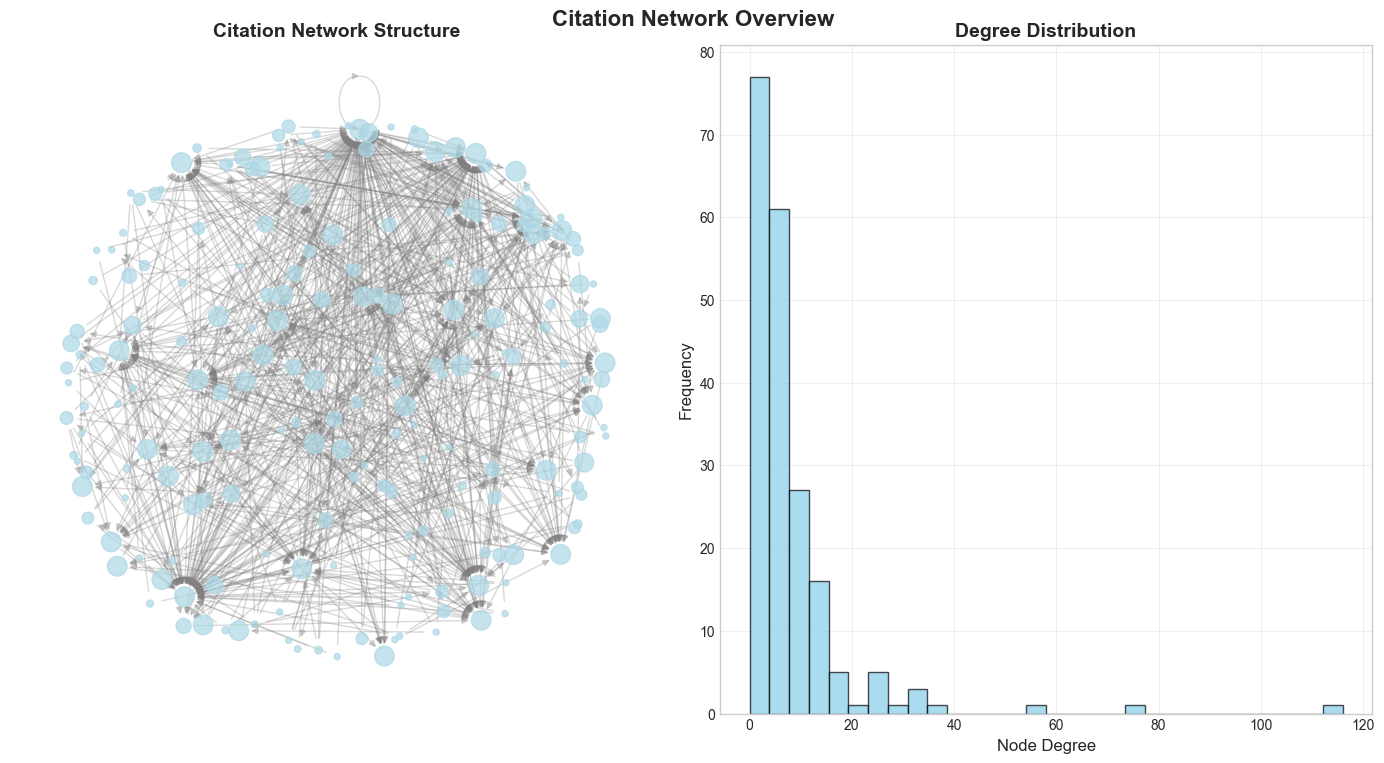

In [18]:
# Create network overview visualization
print("Creating network overview visualization...")

# For visualization, sample a subset if network is too large
if G.number_of_nodes() > 200:
    # Sample high-degree nodes for visualization
    high_degree_nodes = degree_df.nlargest(100, 'total_degree')['node_id'].tolist()
    medium_degree_nodes = degree_df[
        (degree_df['total_degree'] >= 3) & 
        (~degree_df['node_id'].isin(high_degree_nodes))
    ].sample(n=min(100, len(degree_df)-100), random_state=42)['node_id'].tolist()
    
    viz_nodes = high_degree_nodes + medium_degree_nodes
    G_viz = G.subgraph(viz_nodes).copy()
    print(f"Visualizing subset: {G_viz.number_of_nodes()} nodes, {G_viz.number_of_edges()} edges")
else:
    G_viz = G
    print(f"Visualizing full network: {G_viz.number_of_nodes()} nodes")

# Create and save network overview
fig = plot_network_overview(
    G_viz, 
    title="Citation Network Overview",
    figsize=(14, 8),
    save_path="../outputs/network_overview.png"
)
plt.show()

## 8. Network Statistics Visualization

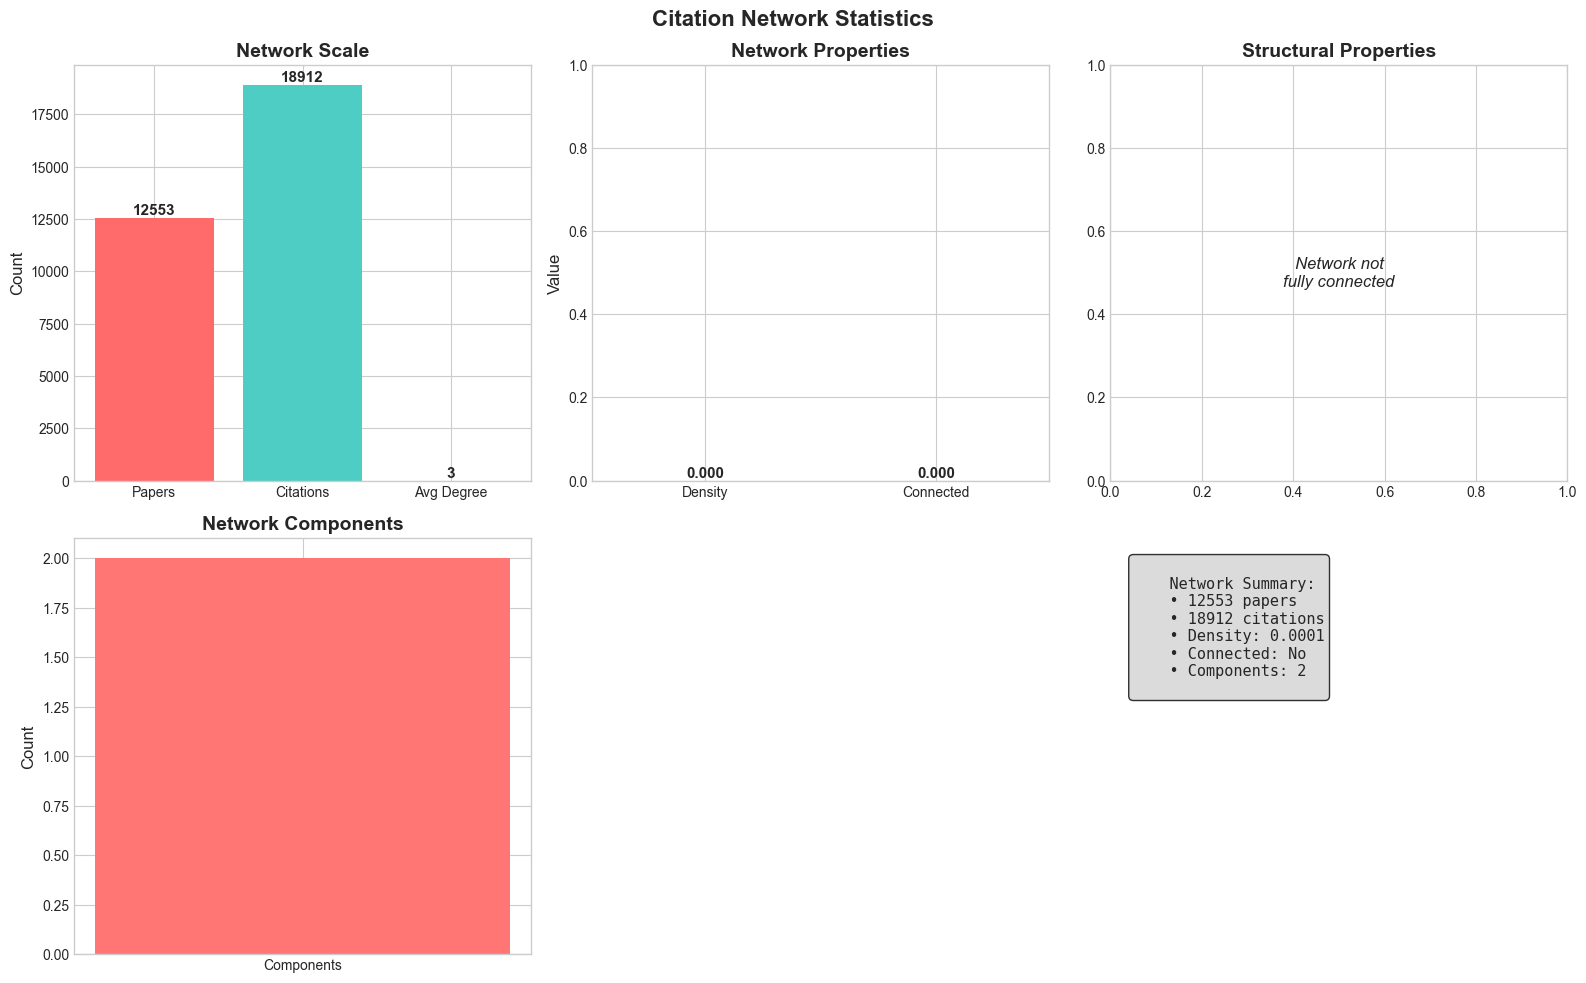

In [19]:
# Create comprehensive statistics visualization
fig = plot_network_statistics(
    network_stats,
    figsize=(16, 10),
    save_path="../outputs/network_statistics.png"
)
plt.show()

## 9. Paper Metadata Analysis

In [20]:
# Get detailed paper metadata
print("Loading paper metadata...")
try:
    metadata_df = extractor.get_paper_metadata()
    print(f"Loaded metadata for {len(metadata_df)} papers")
    
    # Display sample metadata
    print("\nSample Paper Metadata:")
    print(metadata_df.head())
    
    # Citation count analysis
    if 'citations' in metadata_df.columns:
        citation_stats = metadata_df['citations'].describe()
        print("\n📊 Citation Count Statistics:")
        print(citation_stats)
        
except Exception as e:
    print(f"Could not load metadata: {e}")
    metadata_df = pd.DataFrame()

Loading paper metadata...
Loaded metadata for 12595 papers

Sample Paper Metadata:
                                   paper_id  \
0  ae09abb86da331ea16ed87c41f00d84ea93d7bd5   
1  063a1594d32796a6442ac3c78f4cad1db7a1576e   
2  ebf7ed2d69bd6f6c7de048e1c1391cc97ec65a1e   
3  430d827edfbdd39ceb9ebf1a34a181e665335f79   
4  6f7e567d1802a02406571bb45732465fc9acca16   

                                               title authors venues fields  \
0  The impact of clutter on the comprehension of ...      []     []     []   
1  Learning where to look with movement-based int...      []     []     []   
2  Running head : LATEST 1 LATEST : A Model of Sa...      []     []     []   
3  Influence of scene structure and content on vi...      []     []     []   
4  Visual search is guided to categorically-defin...      []     []     []   

   citations  
0        2.0  
1        9.0  
2        0.0  
3        4.0  
4        7.0  

📊 Citation Count Statistics:
count    12589.000000
mean        37.972833
s

## 10. Summary and Key Insights

In [21]:
# Generate comprehensive summary
print("\n" + "="*60)
print("📋 NETWORK EXPLORATION SUMMARY")
print("="*60)

print(f"\n🔢 Scale:")
print(f"   • {network_stats['num_papers']:,} papers in the network")
print(f"   • {network_stats['num_citations']:,} citation relationships")
print(f"   • {network_stats['density']:.6f} network density")

print(f"\n🔗 Connectivity:")
print(f"   • {'Connected' if network_stats['is_connected'] else 'Not fully connected'}")
print(f"   • {network_stats['num_components']} connected components")
print(f"   • {network_stats['avg_degree']:.2f} average degree")

if 'avg_path_length' in network_stats:
    print(f"\n📏 Structure:")
    print(f"   • {network_stats['avg_path_length']:.2f} average path length")
    print(f"   • {network_stats['clustering_coefficient']:.4f} clustering coefficient")

print(f"\n📈 Degree Distribution:")
print(f"   • Max in-degree (most cited): {degree_df['in_degree'].max()}")
print(f"   • Max out-degree (most refs): {degree_df['out_degree'].max()}")
print(f"   • Mean degree: {degree_df['total_degree'].mean():.2f}")

print(f"\n🎯 Next Steps for TransE Model:")
print(f"   • Network is suitable for link prediction with {len(extractor.citation_edges):,} positive examples")
print(f"   • Can generate negative samples from {extractor.num_entities * (extractor.num_entities-1) - len(extractor.citation_edges):,} non-citations")
print(f"   • Embedding dimension should capture the network's complexity")

print(f"\n💾 Files saved:")
print(f"   • ../outputs/network_overview.png")
print(f"   • ../outputs/network_statistics.png")
print(f"   • ../outputs/degree_distributions.png")

print("\n✅ Network exploration complete! Ready for model training.")


📋 NETWORK EXPLORATION SUMMARY

🔢 Scale:
   • 12,553 papers in the network
   • 18,912 citation relationships
   • 0.000120 network density

🔗 Connectivity:
   • Not fully connected
   • 2 connected components
   • 3.01 average degree

📈 Degree Distribution:
   • Max in-degree (most cited): 2096
   • Max out-degree (most refs): 51
   • Mean degree: 3.01

🎯 Next Steps for TransE Model:
   • Network is suitable for link prediction with 18,912 positive examples
   • Can generate negative samples from 157,546,344 non-citations
   • Embedding dimension should capture the network's complexity

💾 Files saved:
   • ../outputs/network_overview.png
   • ../outputs/network_statistics.png
   • ../outputs/degree_distributions.png

✅ Network exploration complete! Ready for model training.


In [22]:
# Clean up database connection
db.close()
print("Database connection closed.")

Database connection closed.
